In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

import numpy as np
import pandas as pd
from base import BaseModel, GarchBase
from stats import loglikelihood_normal, loglikelihood_student_t
from weights import Beta
from helper_functions import create_matrix
from datetime import datetime, timedelta
import time
import scipy.stats as stats
from volatility import Panel_GARCH
import matplotlib.pyplot as plt

In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [8]:
class Panel_GARCH_CSA(BaseModel):
    def __init__(self, plot = True, dist = 'normal', *args):
        self.plot = plot
        self.dist = dist
        self.args = args
    
    def initialize_params(self, X):
        if self.dist == 'normal':
            self.init_params = np.array([0.1, 0.4, 0.4])
        elif self.dist == 'student-t':
            self.init_params = np.array([0.1, 0.4, 0.4, 4.0])
        else:
            raise ValueError("ValueError exception thrown")
        return self.init_params
    
    def model_filter(self, params, X):
        c = np.zeros(X.shape[0])
        sigma2 = np.zeros_like(X)
        
        phi, alpha, beta = params[0], params[1], params[2]
        
        uncond_var = np.nanmean(X ** 2, axis = 0)
        nans = X.isna().sum().values
        X = X.values
        
        for i in range(sigma2.shape[0]):
            if i == 0:
                c[i] = 1
            else:
                c[i] = (1 - phi) + phi * np.nanstd(X[i-1] / (np.sqrt(sigma2[i-1]) * c[i - 1]), ddof = 1)
            for j in range(sigma2.shape[1]):
                if nans[j] == i:
                    sigma2[i][j] = uncond_var[j]
                elif nans[j] < i:
                    sigma2[i][j] = uncond_var[j] * (1 - alpha - beta) + alpha * ((X[i - 1][j] / (np.sqrt(sigma2[i-1][j])*c[i-1])) ** 2) + beta * sigma2[i - 1][j]
                else:
                    pass
        return sigma2, c
    
    def loglikelihood(self, params, X):
        sigma2, _ = self.model_filter(params, X)
        if self.dist == 'normal':
            lls = loglikelihood_normal(X, sigma2).sum()
        elif self.dist == 'student-t':
            lls = loglikelihood_student_t(X, sigma2, params[3]).sum()
        return lls
    
    def simulate(self, params = [0.1, 0.2, 0.6], num = 100, length = 500):
        c = np.zeros(length)
        sigma2 = np.zeros((length, num))
        ret = np.zeros((length, num))
        
        phi, alpha, beta = params[0], params[1], params[2]
        
        for t in range(length):
            if t == 0:
                c[t] = 1.0
                sigma2[t] = 1.0
            else:
                c[t] = (1 - phi) + phi * np.nanstd(ret[t - 1] / (np.sqrt(sigma2[t - 1]) * c[t - 1]), ddof = 1)
                mu = np.mean(ret[ : t] ** 2, axis = 0)
                sigma2[t] = mu * (1 - alpha - beta) + alpha * (ret[t - 1] / (np.sqrt(sigma2[t - 1]) * c[t - 1])) ** 2 + beta * sigma2[t - 1]
            
            ret[t] = stats.norm.rvs(loc = 0.0, scale = np.sqrt(sigma2[t]))
                
        return ret, sigma2, c
    
    def forecast(self, X, H):
        X_new = X
        X_new.loc[X.shape[0]] = 0
        
        sigma2, _ = self.model_filter(self.optimized_params, X_new)
        sigma2 = sigma2 * np.sqrt(H)
        return sigma2[-1]

In [9]:
mod1 = Panel_GARCH()

In [10]:
mod2 = Panel_GARCH_CSA()

In [11]:
ret, sigma, c = mod2.simulate([0.1, 0.05, 0.85], num = 100, length = 1000)

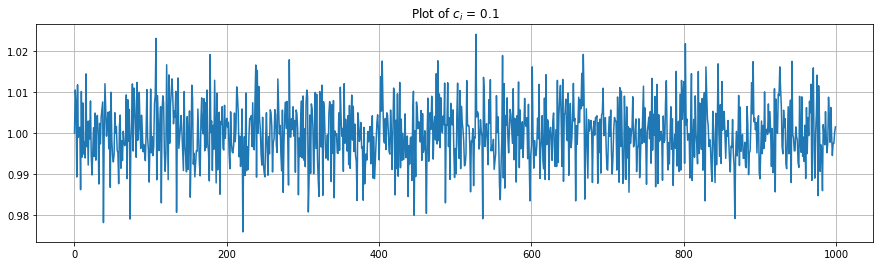

In [12]:
plt.figure(figsize = (15,4))
plt.plot(c)
plt.title('Plot of $c_i$ = 0.1')
plt.grid(True)
plt.show()

In [13]:
mod2.fit(['01', '01', '01'], pd.DataFrame(ret))

Loglikelihood:  141.31517584244887 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000219        0.834450     -1.635272       1.635710
1    0.048522        0.014135      0.020817       0.076227
2    0.809418        0.017670      0.774786       0.844051


In [16]:
_, c_sim = mod2.model_filter(mod2.optimized_params, pd.DataFrame(ret))

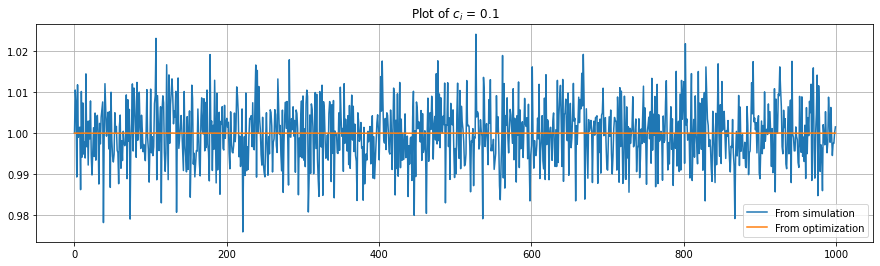

In [20]:
plt.figure(figsize = (15,4))
plt.plot(c, label = "From simulation")
plt.plot(c_sim, label = 'From optimization')
plt.title('Plot of $c_i$ = 0.1')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

# Let's simulate Panel GARCH with cross sectional adjustment with $\phi$ = 0.0, <br>$\alpha$ = 0.05 and $\beta$ = 0.85

In [21]:
ret, sigma, c = mod2.simulate([0.0, 0.05, 0.85], num = 100, length = 1000)

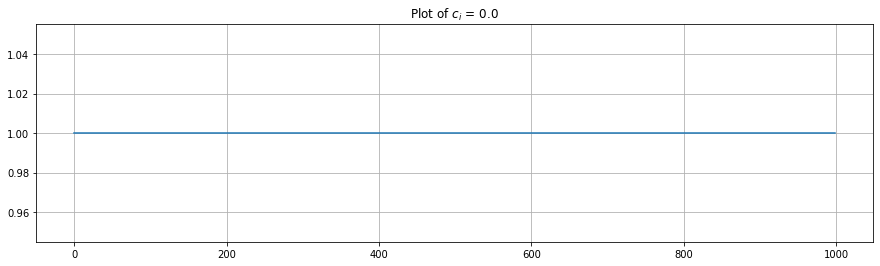

In [22]:
plt.figure(figsize = (15,4))
plt.plot(c)
plt.title('Plot of $c_i$ = 0.0')
plt.grid(True)
plt.show()

In [23]:
mod2.fit(['01', '01', '01'], pd.DataFrame(ret))

Loglikelihood:  141.02475203049278 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000549        2.332172     -4.570423       4.571522
1    0.044444        0.007915      0.028931       0.059957
2    0.810521        0.023747      0.763977       0.857065


In [24]:
mod1.fit(['01', '01'], pd.DataFrame(ret))

Loglikelihood:  140.9803268038624 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.047080        0.015166      0.017355       0.076805
1    0.812756        0.019831      0.773888       0.851624


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from monthdelta import monthdelta

In [26]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]
print(set(nan_index))

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

{455}


In [27]:
ret_mat_nullnan = ret_mat.iloc[:, np.where(ret_mat.isna().sum().values == 0)[0]]

In [28]:
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(0)) & (ret_mat.index < datetime(2005,1,1) + monthdelta(0))]
y_nullnan = ret_mat_nullnan[(ret_mat_nullnan.index >= datetime(1999,12,1) + monthdelta(0)) & (ret_mat_nullnan.index < datetime(2005,1,1) + monthdelta(0))]

In [29]:
model = Panel_GARCH_CSA()
print('---- Teljes Panelra: ----')
model.fit(['01','01', '01'], y)

---- Teljes Panelra: ----


<ipython-input-8-2f4560d01e23>:22: RuntimeWarning: Mean of empty slice
  uncond_var = np.nanmean(X ** 2, axis = 0)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)


Loglikelihood:  916.7800092975514 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000001        0.637507     -1.249489       1.249491
1    0.123286        0.009369      0.104923       0.141649
2    0.421624        0.031254      0.360367       0.482881


In [30]:
_, c_data = model.model_filter(model.optimized_params, y)

<ipython-input-8-2f4560d01e23>:22: RuntimeWarning: Mean of empty slice
  uncond_var = np.nanmean(X ** 2, axis = 0)


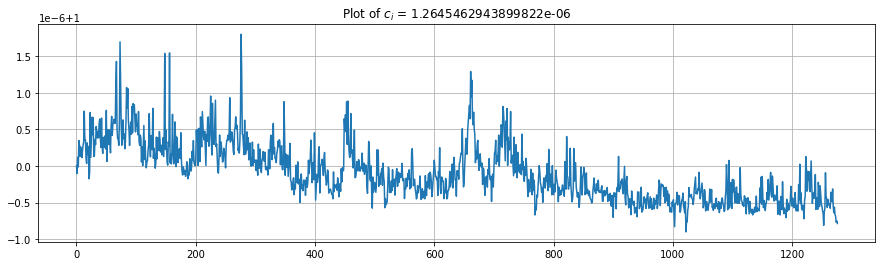

In [31]:
plt.figure(figsize = (15,4))
plt.plot(c_data)
plt.title(f'Plot of $c_i$ = {model.optimized_params[0]}')
plt.grid(True)
plt.show()